In [ ]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.integrate as integrate
from tqdm.auto import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
plt.style.use("default")
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.facecolor": "white",
    }
)

n_dense_points = 201

In [ ]:
class MLP(nn.Module):
    def __init__(self, *features, activation=nn.Tanh):
        super().__init__()

        layers = []
        for in_features, out_features in zip(features, features[1:]):
            layers.append(nn.Linear(in_features, out_features))
            layers.append(activation())
        self.network = nn.Sequential(*layers[:-1])

    def forward(self, x):
        return self.network(x)

In [ ]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

In [ ]:
torch.manual_seed(78)
model = MLP(1, 16, 32, 1)
domain = (0, 1)
t0=0.0
y0=1.0

## PINN I

In [ ]:
batch_size = 10000
n_epochs = 1000
print_interval = n_epochs // 10
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.98 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)


loss_history = []
realloss_history=[]
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # 무작위 t 생성 후 y 계산
    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = model(t)
    y_e=torch.exp(-1*t**2)
    y_t = grad(y, t)

    # Loss
    loss_de = F.mse_loss(-2*t*torch.exp(-1*t**2)- y_t, torch.zeros_like(y_t))
    loss_ic = F.mse_loss(model(torch.tensor([[t0]])), torch.tensor([[y0]]))
    loss = loss_de + loss_ic
    realloss=F.mse_loss(y-y_e, torch.zeros_like(y))
    # Backprop
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    realloss_history.append(realloss.item())
    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_de = {loss_de.item():.4f}, loss_ic = {loss_ic.item():.4f}, loss = {loss.item():.4f}")


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch = 0, loss_de = 0.7686, loss_ic = 0.6722, loss = 1.4409
epoch = 100, loss_de = 0.0259, loss_ic = 0.0002, loss = 0.0261
epoch = 200, loss_de = 0.0190, loss_ic = 0.0001, loss = 0.0191
epoch = 300, loss_de = 0.0191, loss_ic = 0.0001, loss = 0.0192
epoch = 400, loss_de = 0.0183, loss_ic = 0.0001, loss = 0.0184
epoch = 500, loss_de = 0.0184, loss_ic = 0.0001, loss = 0.0184
epoch = 600, loss_de = 0.0182, loss_ic = 0.0001, loss = 0.0183
epoch = 700, loss_de = 0.0188, loss_ic = 0.0001, loss = 0.0189
epoch = 800, loss_de = 0.0182, loss_ic = 0.0001, loss = 0.0183
epoch = 900, loss_de = 0.0183, loss_ic = 0.0001, loss = 0.0184


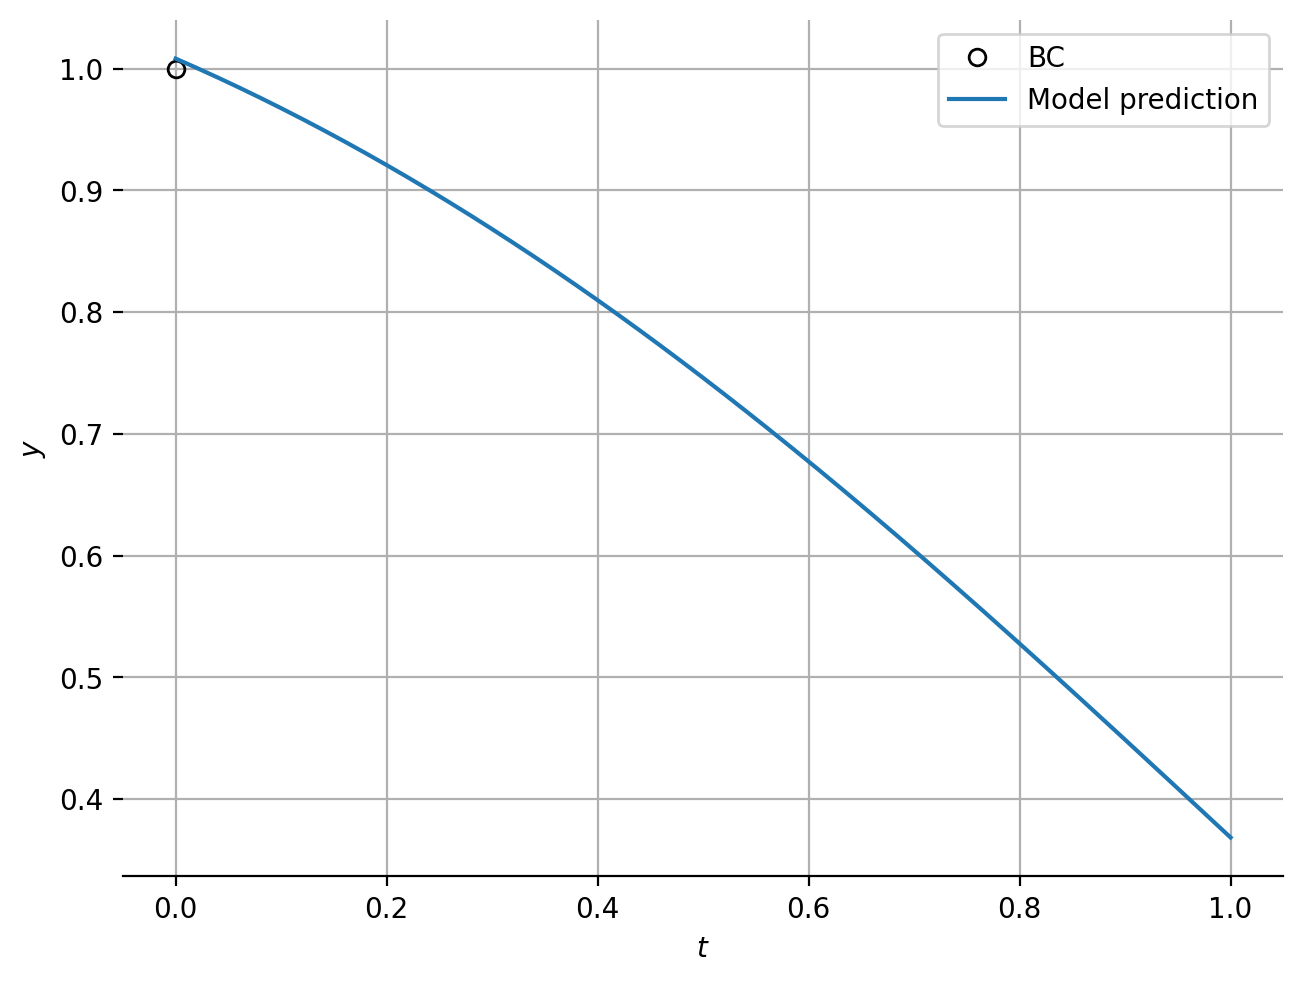

In [ ]:
t_dense=np.linspace(*domain,n_dense_points)
t = torch.tensor(t_dense, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    y = model(t)

fig, ax = plt.subplots()
ax.plot(t0, y0, "ko", mfc="none", label="BC")
ax.plot(t, y, c="C0", label="Model prediction")
ax.set(
    xlabel=r"$t$",
    ylabel=r"$y$"
)
ax.grid()
ax.legend()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

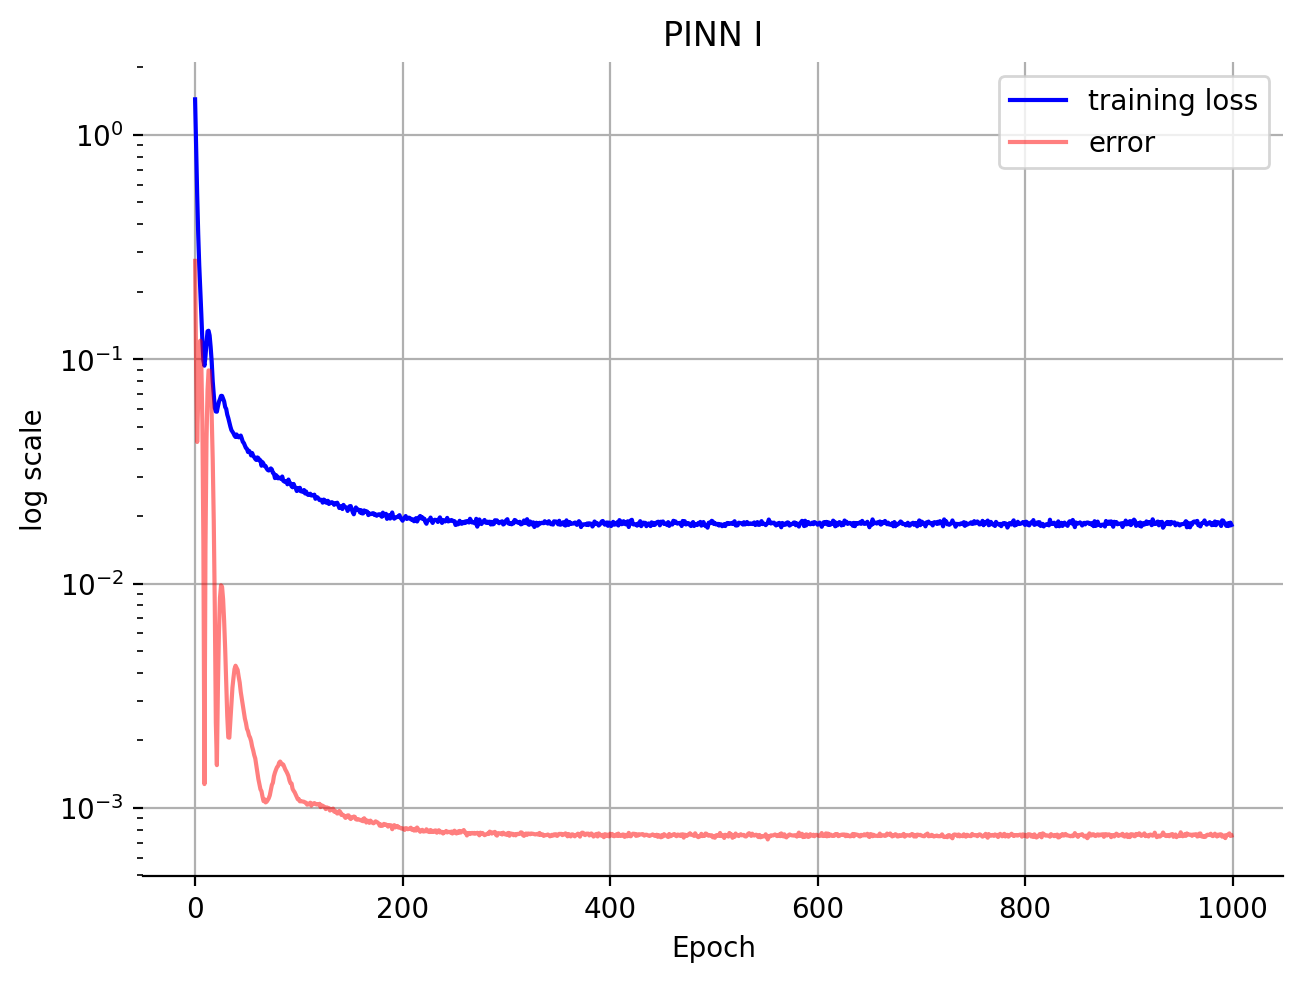

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "training loss")
ax.plot(realloss_history,"r",alpha=0.5, label = "error")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="log scale",
    title = "PINN I"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass


In [ ]:
X=np.array(loss_history)
Y=np.array(realloss_history)

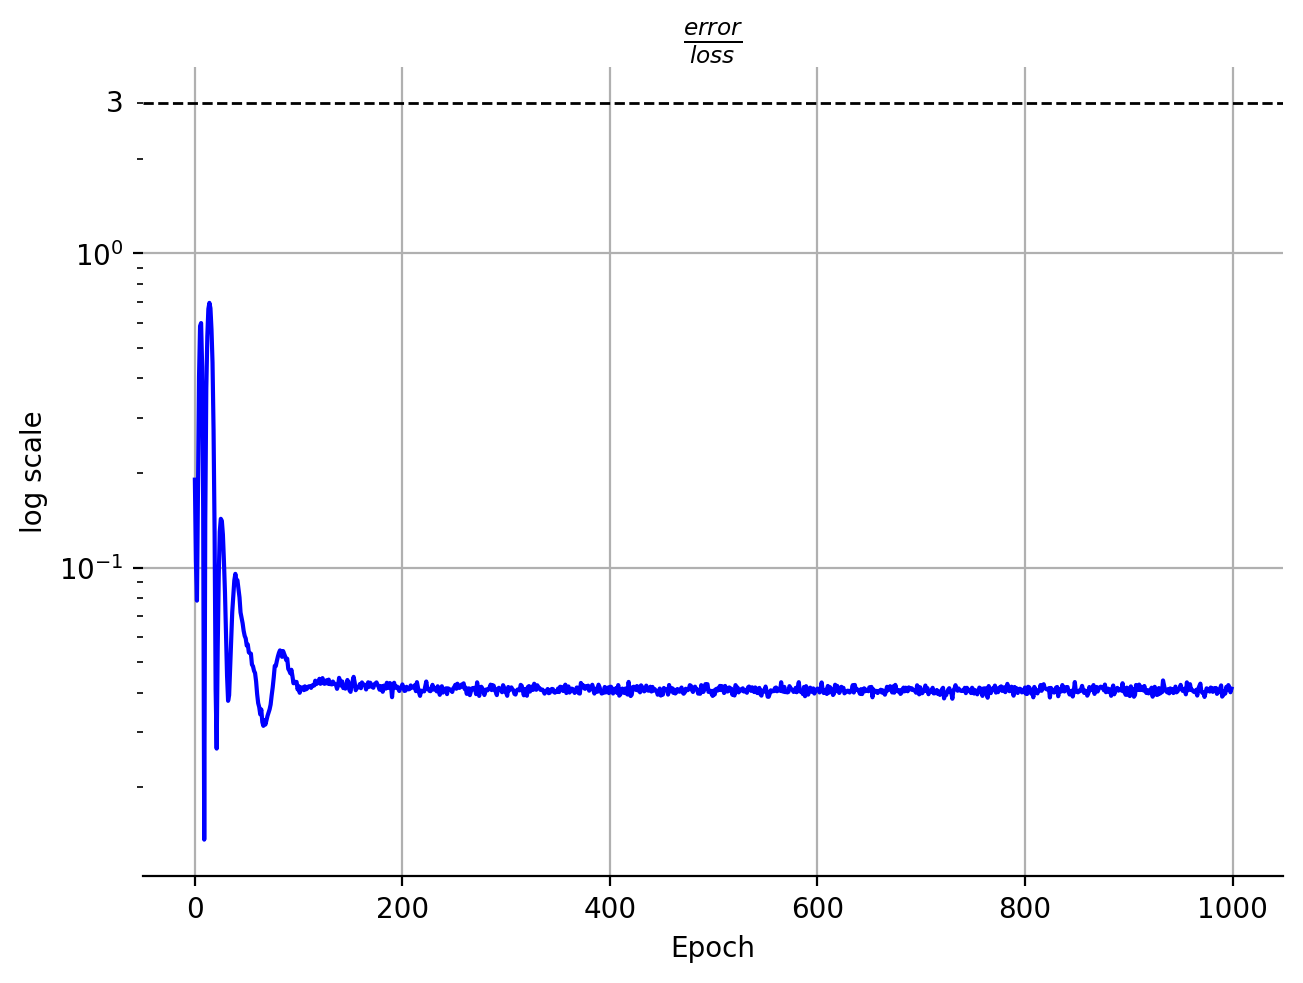

In [ ]:
import matplotlib.transforms as transforms

fig, ax = plt.subplots()
ax.plot(Y/X,"b")
plt.axhline(3, 0, 1, color='black', linestyle='--', linewidth=1)
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0,3, "{:d}".format(3), color="black", transform=trans, ha="right", va="center")
ax.set(
    yscale="log",    ylabel="log scale",    xlabel="Epoch",
    title=r"$\frac{error}{loss}$"
)
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

## PINN II

In [ ]:
torch.manual_seed(78)
model = MLP(1, 16, 32, 1)
print(model)

MLP(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
batch_size = 10000
n_epochs = 1000
print_interval = n_epochs // 10
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.98 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)


loss_history = []
realloss_history=[]
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # 무작위 t 생성 후 y 계산
    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = (t)*model(t)+1.0
    y_e=torch.exp(-1*t**2)
    y_t = grad(y, t)

    # Loss
    loss_de = F.mse_loss(-2*t*torch.exp(-1*t**2)- y_t, torch.zeros_like(y_t))
    loss_bc = F.mse_loss(model(torch.tensor([[t0]])), torch.tensor([[y0]]))
    loss = loss_de
    realloss=F.mse_loss(y-y_e, torch.zeros_like(y))
    # Backprop
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    realloss_history.append(realloss.item())
    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_de = {loss_de.item():.4f}, loss_bc = {loss_bc.item():.4f}, loss = {loss.item():.4f}")


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch = 0, loss_de = 1.1775, loss_bc = 0.6722, loss = 1.1775
epoch = 100, loss_de = 0.0082, loss_bc = 1.3580, loss = 0.0082
epoch = 200, loss_de = 0.0078, loss_bc = 1.3396, loss = 0.0078
epoch = 300, loss_de = 0.0078, loss_bc = 1.3369, loss = 0.0078
epoch = 400, loss_de = 0.0076, loss_bc = 1.3364, loss = 0.0076
epoch = 500, loss_de = 0.0076, loss_bc = 1.3364, loss = 0.0076
epoch = 600, loss_de = 0.0075, loss_bc = 1.3364, loss = 0.0075
epoch = 700, loss_de = 0.0076, loss_bc = 1.3364, loss = 0.0076
epoch = 800, loss_de = 0.0076, loss_bc = 1.3364, loss = 0.0076
epoch = 900, loss_de = 0.0076, loss_bc = 1.3364, loss = 0.0076


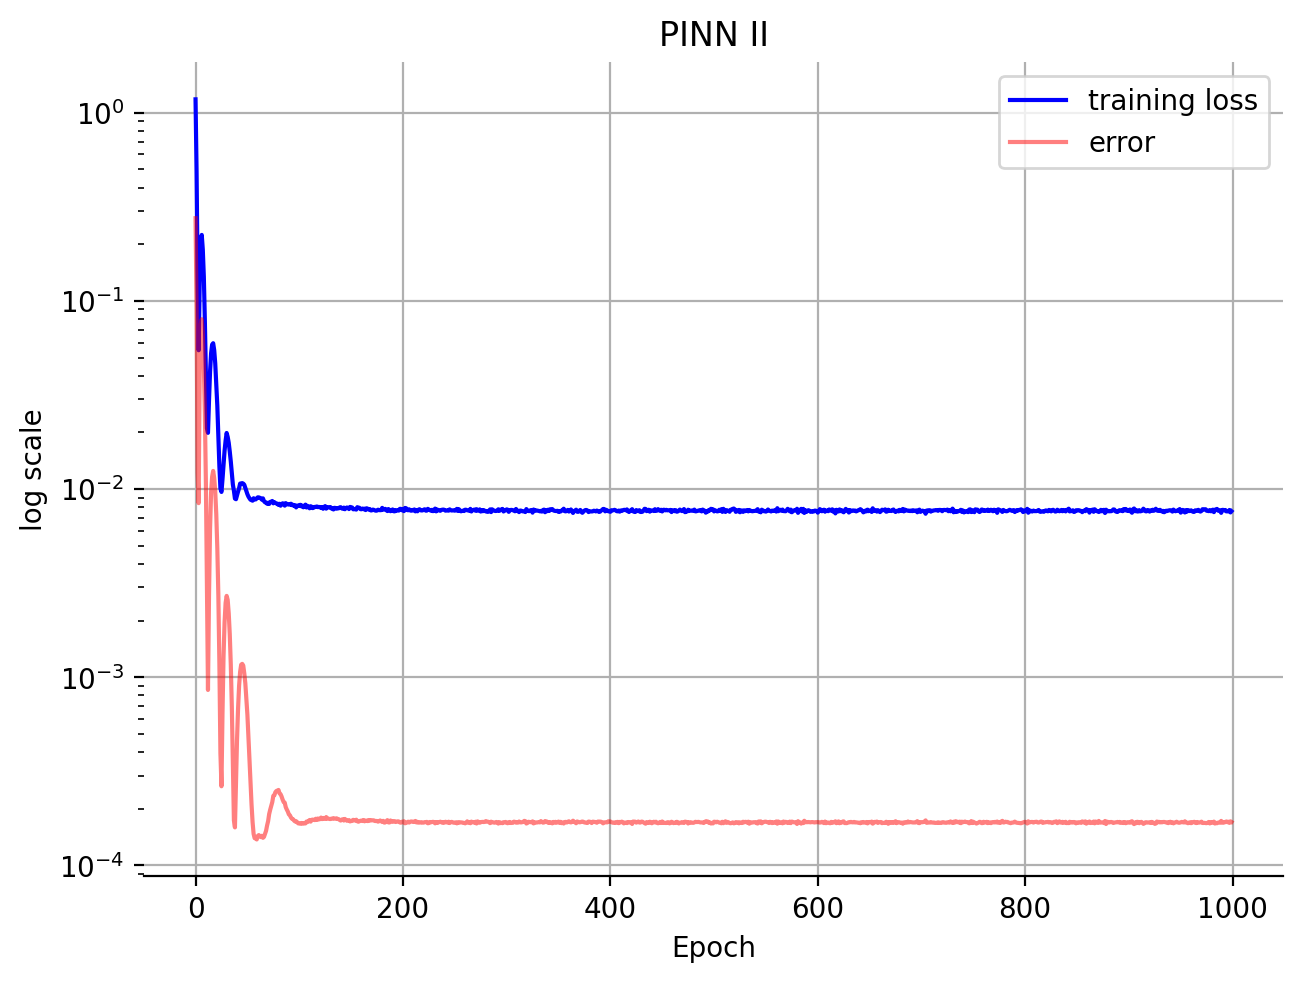

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "training loss")
ax.plot(realloss_history,"r",alpha=0.5, label = "error")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="log scale",
    title = "PINN II"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass


In [ ]:
X=np.array(loss_history)
Y=np.array(realloss_history)

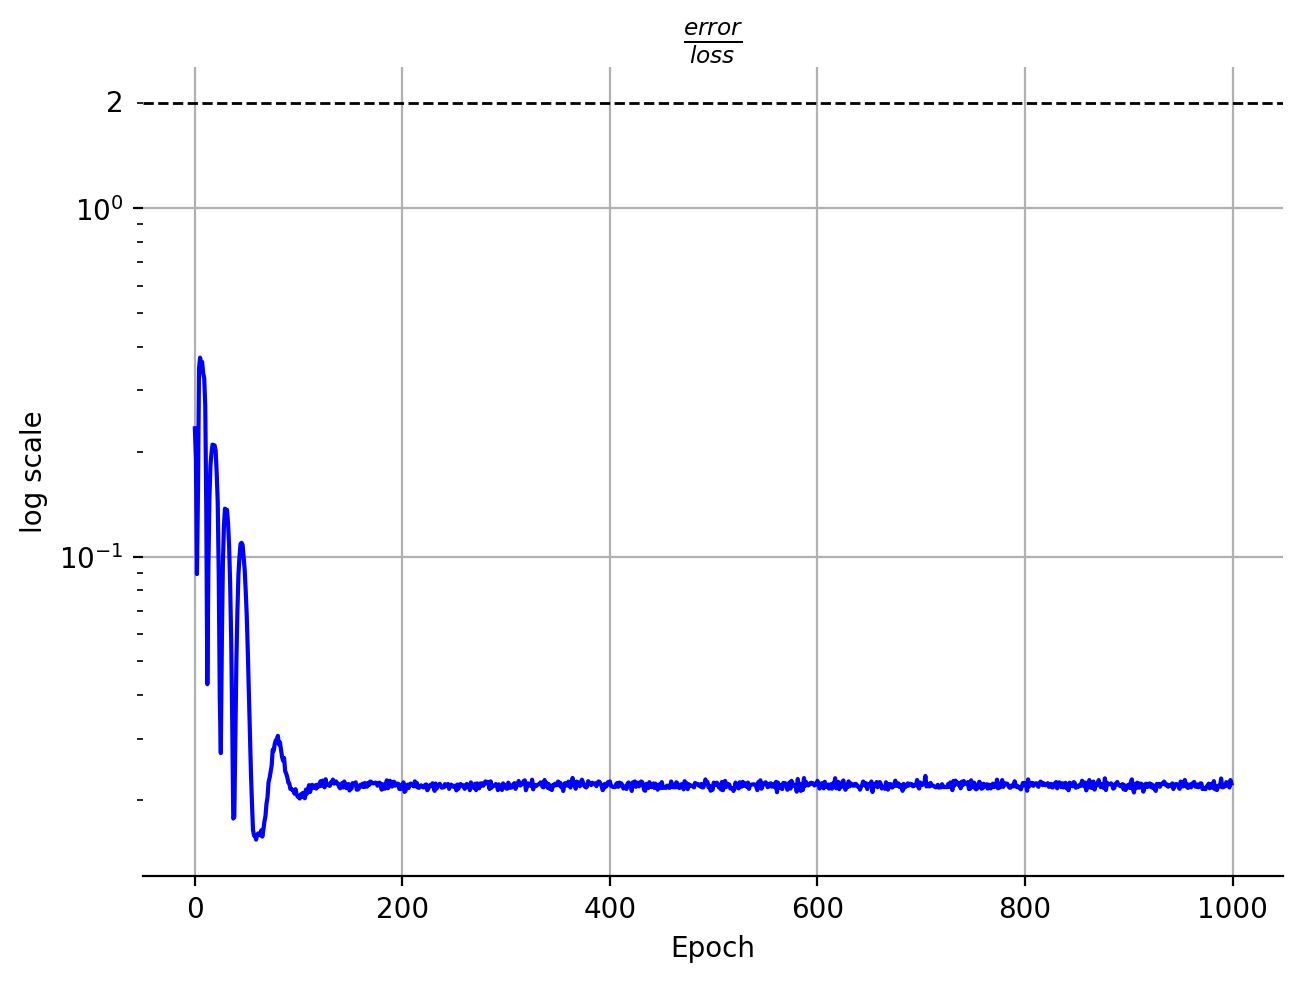

In [ ]:
fig, ax = plt.subplots()
ax.plot(Y/X,"b")
plt.axhline(2, 0, 1, color='black', linestyle='--', linewidth=1)
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, 2, "{:d}".format(2), color="black", transform=trans, ha="right", va="center")
ax.set(
    yscale="log",    ylabel="log scale",    xlabel="Epoch",
    title=r"$\frac{error}{loss}$"
)
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass